# Advanced Portfolio Analysis with Python Notebook 1

## 1. Factor Analysis using the CAPM and Fama-French Factor models

In [1]:
import pandas as pd
import numpy as np

brka_d = pd.read_csv("data/brka_d_ret.csv", parse_dates=True, index_col=0)
brka_d.head()

,BRKA
DATE,
1990-01-02,-0.005764
1990-01-03,0.000000
1990-01-04,0.005797
1990-01-05,-0.005764
1990-01-08,0.000000


In [2]:
# Helper functions to load data
def get_ffme_returns():
    """
    Load the Fama-French Dataset for the returns of the Top and Bottom Deciles by MarketCap
    """
    me_m = pd.read_csv("data/Portfolios_Formed_on_ME_monthly_EW.csv",
                       header=0, index_col=0, na_values=-99.99)
    rets = me_m[['Lo 10', 'Hi 10']]
    rets.columns = ['SmallCap', 'LargeCap']
    rets = rets/100
    rets.index = pd.to_datetime(rets.index, format="%Y%m").to_period('M')
    return rets

def get_fff_returns():
    """
    Load the Fama-French Research Factor Monthly Dataset
    """
    rets = pd.read_csv("data/F-F_Research_Data_Factors_m.csv",
                       header=0, index_col=0, na_values=-99.99)/100
    rets.index = pd.to_datetime(rets.index, format="%Y%m").to_period('M')
    return rets


def get_hfi_returns():
    """
    Load and format the EDHEC Hedge Fund Index Returns
    """
    hfi = pd.read_csv("data/edhec-hedgefundindices.csv",
                      header=0, index_col=0, parse_dates=True)
    hfi = hfi/100
    hfi.index = hfi.index.to_period('M')
    return hfi

def get_ind_file(filetype, weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios files
    Variant is a tuple of (weighting, size) where:
        weighting is one of "ew", "vw"
        number of inds is 30 or 49
    """    
    if filetype is "returns":
        name = f"{weighting}_rets" 
        divisor = 100
    elif filetype is "nfirms":
        name = "nfirms"
        divisor = 1
    elif filetype is "size":
        name = "size"
        divisor = 1
    else:
        raise ValueError(f"filetype must be one of: returns, nfirms, size")
    
    ind = pd.read_csv(f"data/ind{n_inds}_m_{name}.csv", header=0, index_col=0, na_values=-99.99)/divisor
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_returns(weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios Monthly Returns
    """
    return get_ind_file("returns", weighting=weighting, n_inds=n_inds)

def get_ind_nfirms(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    return get_ind_file("nfirms", n_inds=n_inds)

def get_ind_size(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    return get_ind_file("size", n_inds=n_inds)


def get_ind_market_caps(n_inds=30, weights=False):
    """
    Load the industry portfolio data and derive the market caps
    """
    ind_nfirms = get_ind_nfirms(n_inds=n_inds)
    ind_size = get_ind_size(n_inds=n_inds)
    ind_mktcap = ind_nfirms * ind_size
    if weights:
        total_mktcap = ind_mktcap.sum(axis=1)
        ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
        return ind_capweight
    #else
    return ind_mktcap

def get_total_market_index_returns(n_inds=30):
    """
    Load the 30 industry portfolio data and derive the returns of a capweighted total market index
    """
    ind_capweight = get_ind_market_caps(n_inds=n_inds)
    ind_return = get_ind_returns(weighting="vw", n_inds=n_inds)
    total_market_return = (ind_capweight * ind_return).sum(axis="columns")
    return total_market_return

In [3]:
# Summary Statistics of the Portfolio
def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4
 
    
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

In [4]:
def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())

In [5]:
brka_m = brka_d.resample('M').apply(compound).to_period('M')
brka_m.head()

,BRKA
DATE,
1990-01,-0.140634
1990-02,-0.030852
1990-03,-0.069204
1990-04,-0.003717
1990-05,0.067164


In [6]:
# Load the Fama-French Research Factor Monthly Dataset
fff = get_fff_returns()

In [7]:
fff.head()

,Mkt-RF,SMB,HML,RF
1926-07,0.0296,-0.0230,-0.0287,0.0022
1926-08,0.0264,-0.0140,0.0419,0.0025
1926-09,0.0036,-0.0132,0.0001,0.0023
1926-10,-0.0324,0.0004,0.0051,0.0032
1926-11,0.0253,-0.0020,-0.0035,0.0031


Next, we need to decompose the observed BRKA 1990-May 2012 as in Ang(2014) into the portion that's due to the market and the rest that is not due to the market, using the CAPM as the explanatory model.

i.e.

$$ R_{brka,t} - R_{f,t} = \alpha + \beta(R_{mkt,t} - R_{f,t}) + \epsilon_t $$

We can use the `stats.api` for the linear regression as follows:

In [8]:
import statsmodels.api as sm
import numpy as np
brka_excess = brka_m["1990":"2012-05"] - fff.loc["1990":"2012-05", ['RF']].values
mkt_excess = fff.loc["1990":"2012-05",['Mkt-RF']]
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
lm = sm.OLS(brka_excess, exp_var).fit()

In [9]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     48.45
Date:                Mon, 27 Jul 2020   Prob (F-statistic):           2.62e-11
Time:                        12:21:37   Log-Likelihood:                 388.47
No. Observations:                 269   AIC:                            -772.9
Df Residuals:                     267   BIC:                            -765.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5402      0.078      6.961      0.000       0.387       0.693
Constant       0.0061      0.004      1.744      0.082      -0.001       0.013
==============================================================================
Omnibus:                       45.698   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.573
Skew:                           0.825   Prob(JB):                     5.33e-23
Kurtosis:                       5.535   Cond. No.                         22.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 1.1 The CAPM benchmark interpretation

This implies that the CAPM benchmark consists of 46 cents in T-Bills and 54 cents in the market. i.e. each dollar in the Berkshire Hathaway portfolio is equivalent to 46 cents in T-Bills and 54 cents in the market. Relative to this, the Berkshire Hathaway is adding (i.e. has  𝛼  of) 0.61% (per month!) although the degree of statistica significance is not very high.

Now, let's add in some additional explanatory variables, namely Value and Size.

In [10]:
exp_var["Value"] = fff.loc["1990":"2012-05",['HML']]
exp_var["Size"] = fff.loc["1990":"2012-05",['SMB']]
exp_var.head()

,Mkt-RF,Constant,Value,Size
1990-01,-0.0785,1,0.0087,-0.0129
1990-02,0.0111,1,0.0061,0.0103
1990-03,0.0183,1,-0.0290,0.0152
1990-04,-0.0336,1,-0.0255,-0.0050
1990-05,0.0842,1,-0.0374,-0.0257


In [11]:
lm = sm.OLS(brka_excess, exp_var).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     36.06
Date:                Mon, 27 Jul 2020   Prob (F-statistic):           1.41e-19
Time:                        12:21:37   Log-Likelihood:                 412.09
No. Observations:                 269   AIC:                            -816.2
Df Residuals:                     265   BIC:                            -801.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.6761      0.074      9.155      0.000       0.531       0.821
Constant       0.0055      0.003      1.679      0.094      -0.001       0.012
Value          0.3814      0.109      3.508      0.001       0.167       0.595
Size          -0.5023      0.101     -4.962      0.000      -0.702      -0.303
==============================================================================
Omnibus:                       42.261   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.954
Skew:                           0.904   Prob(JB):                     1.75e-15
Kurtosis:                       4.671   Cond. No.                         37.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 1.2 The Fama-French Benchmark Interpretation

The new way to interpret each dollar invested in Hathaway is: 67 cents in the market, 33 cents in Bills, 38 cents in Value stocks and short 38 cents in Growth stocks, short 50 cents in SmallCap stocks and long 50 cents in LargeCap stocks. If you did all this, you would still end up underperforming Hathaway by about 55 basis points per month.

We can interpret the loadings on Value being positive as saying that Hathaway has a significant Value tilt - which should not be a shock to anyone that follows Buffet. Additionally, the negative tilt on size suggests that Hathaway tends to invest in large companies, not small companies.

In [12]:
import statsmodels.api as sm
def regress(dependent_variable, explanatory_variables, alpha=True):
    """
    Runs a linear regression to decompose the dependent variable into the explanatory variables
    returns an object of type statsmodel's RegressionResults on which you can call
       .summary() to print a full summary
       .params for the coefficients
       .tvalues and .pvalues for the significance levels
       .rsquared_adj and .rsquared for quality of fit
    """
    if alpha:
        explanatory_variables = explanatory_variables.copy()
        explanatory_variables["Alpha"] = 1

    lm = sm.OLS(dependent_variable, explanatory_variables).fit()
    return lm

# 2. Sharpe Style Analysis
Sharpe Style Analysis is an elegant and simple decomposition exercise similar to what we did in the previous lab session, with the added constraint that the coefficients are all positive and add to 1.

Therefore, the coefficients of performing style analysis on the observed return of a manager can be interpreted as weights in a portfolio of building blocks which together, mimic that return series.

## 2.1 Performing Sharpe Style Analysis
We are asking the optimizer to find the weights that minimizes the square of the difference between the observed series and the returns of a benchmark portfolio that holds the explanatory building blocks in those same weights. This is equivalent to minimizing the tracking error between the two return series.

In [13]:
from scipy.optimize import minimize

def style_analysis(dependent_variable, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error between
    a portfolio of the explanatory variables and the dependent variable
    """
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    solution = minimize(portfolio_tracking_error, init_guess,
                       args=(dependent_variable, explanatory_variables,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    weights = pd.Series(solution.x, index=explanatory_variables.columns)
    return weights

def portfolio_tracking_error(weights, ref_r, bb_r):
    """
    returns the tracking error between the reference returns
    and a portfolio of building block returns held with given weights
    """
    return tracking_error(ref_r, (weights*bb_r).sum(axis=1))

def tracking_error(r_a, r_b):
    """
    Returns the Tracking Error between the two return series
    """
    return np.sqrt(((r_a - r_b)**2).sum())

In [14]:
brka_m = pd.read_csv("brka_m.csv", index_col=0, parse_dates=True).to_period('M')
ind49_rets = get_ind_returns()["2000":]

In [15]:
mgr_r_b = brka_m["2000":]["BRKA"]
weights_b = style_analysis(mgr_r_b, ind49_rets)
weights_b.sort_values(ascending=False).head(6).round(4)*100

Food     41.35
Fin      17.61
Meals    12.11
Other    11.03
Util      7.19
Clths     5.99
dtype: float64

# 3. Back Test: EW vs CW

In [16]:
# Strategy 1: Equal Weights with microcap limits
def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        ## exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum() #reweight
    return ew

# Strategy 2: Market Capitalization Weighted
def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[0]]
    return w/w.sum()

# Back Tester
def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

In [17]:
ind49_rets = get_ind_returns(n_inds=49)["1990":]
ind49_mcap = get_ind_market_caps(n_inds=49,weights=True)["1990":]

In [18]:
ewr = backtest_ws(ind49_rets)
ewtr = backtest_ws(ind49_rets, cap_weights=ind49_mcap, max_cw_mult=5, microcap_threshold=.005)
cwr = backtest_ws(ind49_rets, weighting=weight_cw, cap_weights=ind49_mcap)
btr = pd.DataFrame({"EW": ewr, "EW-Tethered": ewtr, "CW": cwr})
# From return to price
(1+btr).cumprod().plot(figsize=(12,5))
summary_stats(btr.dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.104808,0.155390,-0.724438,5.801234,0.070544,0.104682,0.468379,-0.528292
EW-Tethered,0.105807,0.152320,-0.750831,5.281953,0.069686,0.100711,0.484208,-0.530654
CW,0.100268,0.146049,-0.712416,4.521272,0.067165,0.096851,0.468102,-0.515999


## 4. Estimating Covariance

### 3.1 Building the Global Minimum Variance Portfolio

In [19]:
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns


def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return gmv(est_cov)

def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.104808,0.155390,-0.724438,5.801234,0.070544,0.104682,0.468379,-0.528292
CW,0.100268,0.146049,-0.712416,4.521272,0.067165,0.096851,0.468102,-0.515999
GMV-Sample,0.105093,0.082846,-0.589898,4.012885,0.033981,0.047953,0.882155,-0.233730


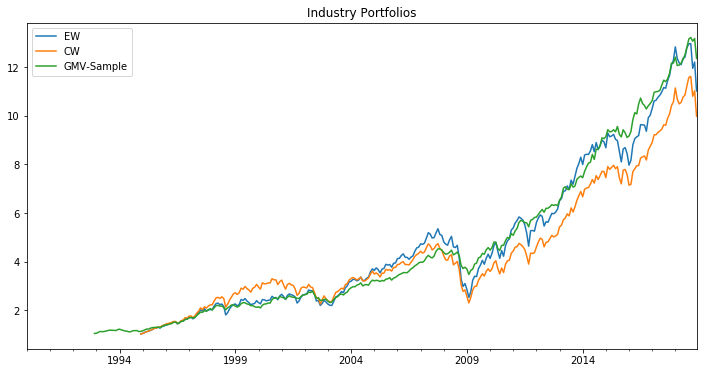

In [20]:
mv_s_r = backtest_ws(ind49_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
summary_stats(btr.dropna())

### 3.2 Constant Correlation
Now, let's try a new estimator - Constant Correlation. The idea is simple, take the sample correlation matrix, compute the average correlation and then reconstruct the covariance matrix. The relation between correlations $\rho$ and covariance $\sigma$ is given by:

$$ \rho_{ij} = \frac{ \sigma_{ij} } { \sqrt{ \sigma_{ii}  \sigma_{jj} } } $$

In [21]:
def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    ccov = ccor * np.outer(sd, sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

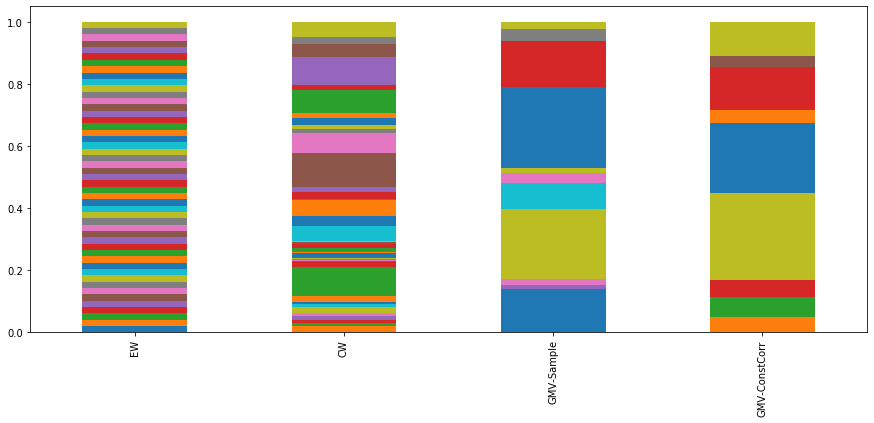

In [22]:
wts = pd.DataFrame({
    "EW": weight_ew(ind49_rets["2016":]),
    "CW": weight_cw(ind49_rets["2016":], cap_weights=ind49_mcap["2016":]),
    "GMV-Sample": weight_gmv(ind49_rets["2016":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind49_rets["2016":], cov_estimator=cc_cov),
})
wts.T.plot.bar(stacked=True, figsize=(15,6), legend=False)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.104808,0.155390,-0.724438,5.801234,0.070544,0.104682,0.468379,-0.528292
CW,0.100268,0.146049,-0.712416,4.521272,0.067165,0.096851,0.468102,-0.515999
GMV-Sample,0.105093,0.082846,-0.589898,4.012885,0.033981,0.047953,0.882155,-0.233730
GMV-CC,0.110182,0.097488,-0.594402,3.766034,0.041192,0.058937,0.800428,-0.249225


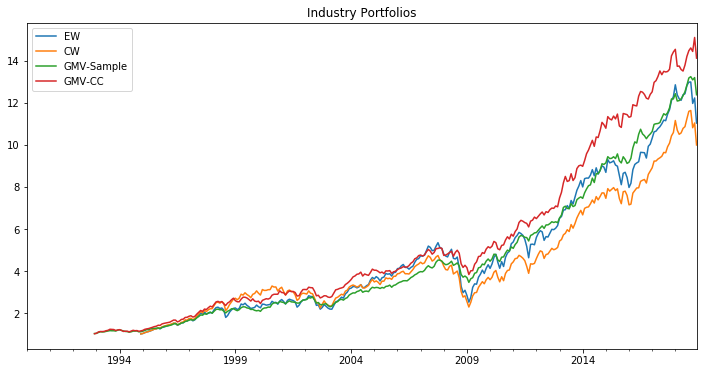

In [23]:
mv_cc_r = backtest_ws(ind49_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=cc_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
summary_stats(btr.dropna())

### 3.3 Statistical Shrinkage
We can mix the model and sample estimates by choosing a shrinkage parameter. You can either let the numbers dictate an optimal shrinkage value for  𝛿  although in practice many practiotioners choose  0.5 . Let's implement a simple shrinkage based covariance estimator that shrinks towards the Constant Correlation estimate.

In [24]:
def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

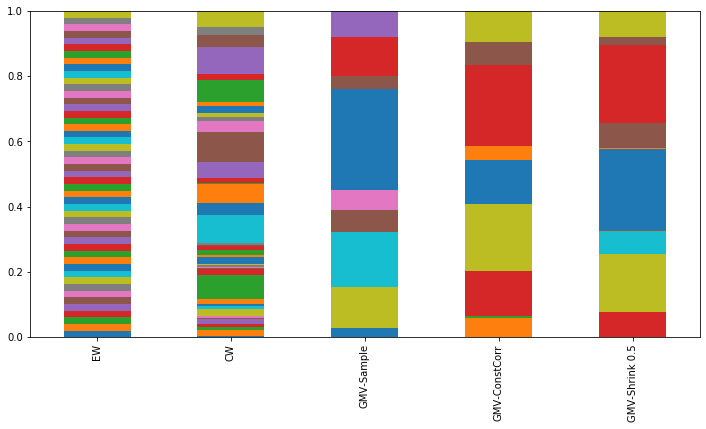

In [25]:
wts = pd.DataFrame({
    "EW": weight_ew(ind49_rets["2013":]),
    "CW": weight_cw(ind49_rets["2013":], cap_weights=ind49_mcap["2013":]),
    "GMV-Sample": weight_gmv(ind49_rets["2013":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind49_rets["2013":], cov_estimator=cc_cov),
    "GMV-Shrink 0.5": weight_gmv(ind49_rets["2013":], cov_estimator=shrinkage_cov),
})
wts.T.plot.bar(stacked=True, figsize=(12,6), legend=False);

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.104808,0.155390,-0.724438,5.801234,0.070544,0.104682,0.468379,-0.528292
CW,0.100268,0.146049,-0.712416,4.521272,0.067165,0.096851,0.468102,-0.515999
GMV-Sample,0.105093,0.082846,-0.589898,4.012885,0.033981,0.047953,0.882155,-0.233730
GMV-CC,0.110182,0.097488,-0.594402,3.766034,0.041192,0.058937,0.800428,-0.249225
GMV-Shrink 0.5,0.109115,0.089093,-0.617125,3.857957,0.037108,0.052675,0.864222,-0.238543


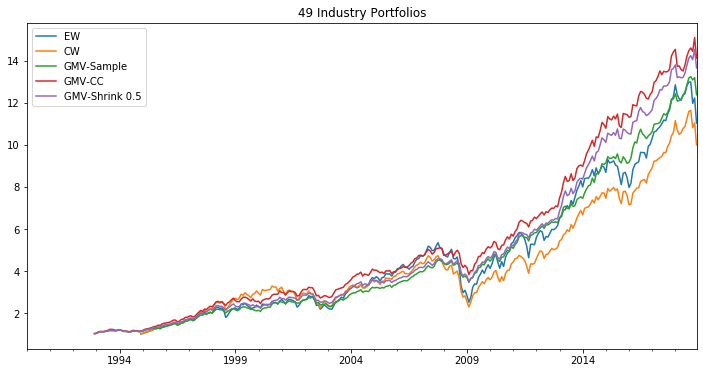

In [26]:
mv_sh_r = backtest_ws(ind49_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.5)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r, 'GMV-Shrink 0.5': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="49 Industry Portfolios")
summary_stats(btr.dropna())

## 5. Estimate Returns --- Black-Litterman Model

### The Black Litterman Formulas

Assume that we have $N$ assets, and $K$ views. There are two sets of inputs to the procedure. The first set of inputs relate to market parameters and these are:

\begin{array}{ll}
w & \mbox{A Column Vector ($N \times 1$) of Equilibrium Market Weights of the Assets} \\
\Sigma & \mbox{A Covariance Matrix ($N \times N$) of the Assets} \\
R_f & \mbox{The Risk Free Rate} \\
\delta & \mbox{The investor's Risk Aversion parameter}  \\
\tau & \mbox{A scalar indicating the uncertainty of the prior (details below)}
\end{array}


Some of these parameters can be inferred from other parameters if they are not explicitly specified. For instance, the risk aversion parameter can be set arbitrarily. For instance, some authors use $\delta = 2.5$ while others use the value of $\delta = 2.14$ in order to be consistent with the value calculated in \cite{dimson2008triumph}.

\cite{beach2007application} suggest using $2.65$. Another common approach is to set $\delta$ to the Market Price of Risk (i.e. a measure of the risk aversion of the Representative Investor, which is computed as $\delta = \mu_M/\sigma^2_M$ where $\mu_M$ and $\sigma^2_M$ are estimates of the mean and variance of the returns of the market portfolio. Frequently, a broad market index such as the S\&P500 is taken as a proxy for the market in order to compute the market price of risk from $\mu_M$ and $\sigma^2_M$.

The treatment of $\tau$ is the source of some confusion. As we will explain in the following section, some implementors have done away with $\tau$ by setting it to $1$ or to calibrate the model to $tau$. In the original model, Black and Litterman suggest using a small number. A common technique is to set $\tau = 1/T$ where $T$ is the number of periods of data used. Thus, for $T=5$ you would use $1/(5 \times 12)$ which yields a value of approximately $\tau=.02$.

The second set of inputs that the procedure needs is a representation of the investors views. These are specified via:

\begin{array}{ll}
Q & \mbox{An $K \times 1$ ``Qualitative Views'' or simply, Views matrix} \\
P & \mbox{A $K \times N$ ``Projection'' or ``Pick'' matrix, linking each view to the assets} \\
\Omega & \mbox{A Covariance matrix representing the uncertainty of views}
\end{array}


Views are represented in $Q$ and $P$ as follows:

If the $k$-th view is an absolute view, it is represented by setting $Q_k$ to the expected return of asset $k$ and setting $P_{ki}$ to 1 and all other elements of row $k$ in $P$ to zero.

If the $k$-th view is an relative view, between assets $i$ and $j$ it is represented by setting $Q_k$ to the expected difference of returns between assets $i$ and $j$, and setting $P_{ki}$ to $-1$ for the underperforming asset, $P_{kj}$ to $+1$ and all other elements of row $k$ in $P$ to zero. $\Omega$ is either set to the specified uncertainty or is inferred from the user or from the data.

The uncertainty of the views $\Omega$ is either set by the user, or inferred (e.g. via statements of confidence, from market data, from the variance of residuals from a prediction model used to generate the views etc, we shall see examples in sections below). In particular, \cite{he1999intuition} suggest setting it to be the diagonal matrix obtained from the diagonal elements of $P \tau \Sigma P^T$, which is what we shall do for some of our initial tests. In my implementation the code accepts a matrix, but uses this assumption as the default if the user does not specify a matrix to use as $\Omega$.

#### The Master Formula

The first step of the procedure is a _reverse-optimization_ step that infers the implied returns vector $\pi$ that are implied by the equilibrium weights $w$ using the formula:

$$\pi = \delta\Sigma w$$

Next, the posterior returns and covariances are obtained from the _Black-Litterman Master Formula_ which is the following set of equations:

\begin{equation}
\label{eq:blMuOrig}
\mu^{BL} = [(\tau\Sigma)^{-1} + P \Omega^{-1} P]^{-1}[(\tau\Sigma)^{-1} \pi + P \Omega^{-1} Q]
\end{equation}

\begin{equation}
\label{eq:blSigmaOrig}
\Sigma^{BL} = \Sigma + [(\tau\Sigma)^{-1} + P \Omega^{-1} P]^{-1}
\end{equation}

### 5.1 PI
the first step in the Black Litterman procedure was to reverse engineer the implied returns vector $\pi$ from a set of portfolio weights $w$. 

$$\pi = \delta\Sigma w$$

This is performed by the following code:

In [27]:
def implied_returns(delta, sigma, w):
    """
Obtain the implied expected returns by reverse engineering the weights
Inputs:
delta: Risk Aversion Coefficient (scalar)
sigma: Variance-Covariance Matrix (N x N) as DataFrame
    w: Portfolio weights (N x 1) as Series
Returns an N x 1 vector of Returns as Series
    """
    ir = delta * sigma.dot(w).squeeze() # to get a series from a 1-column dataframe
    ir.name = 'Implied Returns'
    return ir

### 5.2 Omega
$$\Omega = diag(P (\tau \Sigma) P^T) $$

This is implemented in Python as:

In [28]:
# Assumes that Omega is proportional to the variance of the prior
def proportional_prior(sigma, tau, p):
    """
    Returns the He-Litterman simplified Omega
    Inputs:
    sigma: N x N Covariance Matrix as DataFrame
    tau: a scalar
    p: a K x N DataFrame linking Q and Assets
    returns a P x P DataFrame, a Matrix representing Prior Uncertainties
    """
    helit_omega = p.dot(tau * sigma).dot(p.T)
    # Make a diag matrix from the diag elements of Omega
    return pd.DataFrame(np.diag(np.diag(helit_omega.values)),index=p.index, columns=p.index)

### 5.3 Mu

In [29]:
from numpy.linalg import inv

def bl(w_prior, sigma_prior, p, q,
                omega=None,
                delta=2.5, tau=.02):
    """
# Computes the posterior expected returns based on 
# the original black litterman reference model
#
# W.prior must be an N x 1 vector of weights, a Series
# Sigma.prior is an N x N covariance matrix, a DataFrame
# P must be a K x N matrix linking Q and the Assets, a DataFrame
# Q must be an K x 1 vector of views, a Series
# Omega must be a K x K matrix a DataFrame, or None
# if Omega is None, we assume it is
#    proportional to variance of the prior
# delta and tau are scalars
    """
    if omega is None:
        omega = proportional_prior(sigma_prior, tau, p)
    # Force w.prior and Q to be column vectors
    # How many assets do we have?
    N = w_prior.shape[0]
    # And how many views?
    K = q.shape[0]
    # First, reverse-engineer the weights to get pi
    pi = implied_returns(delta, sigma_prior,  w_prior)
    # Adjust (scale) Sigma by the uncertainty scaling factor
    sigma_prior_scaled = tau * sigma_prior  
    # posterior estimate of the mean, use the "Master Formula"
    # we use the versions that do not require
    # Omega to be inverted (see previous section)
    # this is easier to read if we use '@' for matrixmult instead of .dot()
    #     mu_bl = pi + sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ (q - p @ pi)
    mu_bl = pi + sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega).dot(q - p.dot(pi).values))
    # posterior estimate of uncertainty of mu.bl
#     sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ p @ sigma_prior_scaled
    sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega)).dot(p).dot(sigma_prior_scaled)
    return (mu_bl, sigma_bl)

### 5.4 Case Study

In [30]:
industry_list = ['Hlth', 'Fin', 'Whlsl', 'Rtail', 'Food']
ind_rets = get_ind_returns(weighting="vw", n_inds=49)[industry_list]["2013":]
ind_nfirms = get_ind_nfirms(n_inds=49)[industry_list]["2013":]
ind_size = get_ind_size(n_inds=49)[industry_list]["2013":]
ind_mktcap = ind_nfirms * ind_size
total_mktcap = ind_mktcap.sum(axis=1)
mcap_weights = ind_mktcap.divide(total_mktcap, axis="rows")

In [31]:
# Correlation
rho = pd.DataFrame(ind_rets.corr().values, index=industry_list, columns=industry_list, dtype='float')

#Volatility 
vols = annualize_vol(ind_rets, 12)
vols = pd.DataFrame(vols, columns=['vol'])

In [32]:
w_eq = mcap_weights['2013-01'].values[0]
d = 0.25
# Compute the Covariance Matrix
sigma_prior = vols.dot(vols.T) * rho

In [33]:
implied_returns(delta=d, sigma=sigma_prior, w=w_eq)

Hlth     0.003322
Fin      0.003992
Whlsl    0.003640
Rtail    0.004182
Food     0.002558
Name: Implied Returns, dtype: float64

In [34]:
w_Whlsl = mcap_weights['2013-01']['Whlsl'] / (mcap_weights['2013-01']['Whlsl'] + mcap_weights['2013-01']['Rtail'])
w_Rtail = mcap_weights['2013-01']['Rtail'] / (mcap_weights['2013-01']['Whlsl'] + mcap_weights['2013-01']['Rtail'])

In [35]:
print(w_Whlsl.values, w_Rtail.values)

[0.15130614] [0.84869386]


#### View 1:
Impose the view that Hlth will outperform the Rtail and Whlsl by 3%

In [36]:
q = pd.Series([.03])
p = pd.DataFrame([0.]*len(industry_list), index=industry_list).T
p.iloc[0]['Hlth'] = 1.
p.iloc[0]['Rtail'] = -w_Rtail
p.iloc[0]['Whlsl'] = -w_Whlsl
(p*100).round(1)

,Hlth,Fin,Whlsl,Rtail,Food
0,100.0,0.0,-15.1,-84.9,0.0


In [37]:
w_eq = pd.Series(data=w_eq, index=industry_list)
delta = 2.5
tau = 0.05
bl_mu, bl_sigma = bl(w_eq, sigma_prior, p, q, tau = tau)
# Compute the returns based on Black-Litterman Model
(bl_mu*100).round(1)

Hlth     4.7
Fin      4.0
Whlsl    3.6
Rtail    3.6
Food     2.3
dtype: float64

In [38]:
# Max Sharpe Ratio Portfolio
def inverse(d):
    """
    Invert the dataframe by inverting the underlying matrix
    """
    return pd.DataFrame(inv(d.values), index=d.columns, columns=d.index)

def w_msr(sigma, mu, scale=True):
    """
    Optimal (Tangent/Max Sharpe Ratio) Portfolio weights
    by using the Markowitz Optimization Procedure
    Mu is the vector of Excess expected Returns
    Sigma must be an N x N matrix as a DataFrame and Mu a column vector as a Series
    This implements page 188 Equation 5.2.28 of
    "The econometrics of financial markets" Campbell, Lo and Mackinlay.
    """
    w = inverse(sigma).dot(mu)
    if scale:
        w = w/sum(w) 
    return w

In [39]:
wmsr = w_msr(sigma=bl_sigma, mu=bl_mu)
wmsr

Hlth     0.462975
Fin      0.175362
Whlsl    0.033664
Rtail    0.188824
Food     0.139176
dtype: float64

In [40]:
def w_star(delta, sigma, mu):
    return (inverse(sigma).dot(mu))/delta

wstar = w_star(delta=2.5, sigma=bl_sigma, mu=bl_mu)
wstar

Hlth     0.440928
Fin      0.167011
Whlsl    0.032061
Rtail    0.179832
Food     0.132549
dtype: float64

## 6. Risk Contributions and Risk Parity

In [42]:
inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = get_ind_returns(weighting="vw", n_inds=49)["1974":]
ind_mcap = get_ind_market_caps(49, weights=True)["1974":]

rets = ind_rets["2013":][inds]
cov = rets.cov()

In [45]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

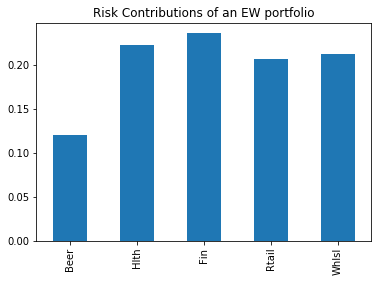

In [46]:
risk_contribution(weight_ew(rets), cov).plot.bar(title="Risk Contributions of an EW portfolio")

In [48]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

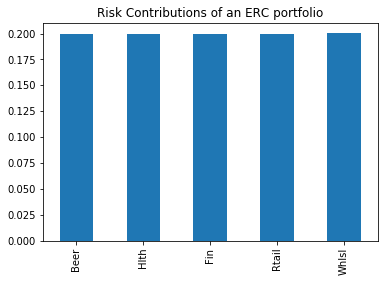

In [49]:
risk_contribution(equal_risk_contributions(cov), cov).plot.bar(title="Risk Contributions of an ERC portfolio")

In [51]:
def weight_erc(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.122596,0.161098,-0.769800,6.556532,0.071949,0.103950,0.559247,-0.528292
CW,0.118341,0.149477,-0.705554,5.436168,0.066722,0.096505,0.575049,-0.518418
ERC-Sample,0.123024,0.144321,-0.884979,7.076898,0.064294,0.092382,0.627197,-0.477161


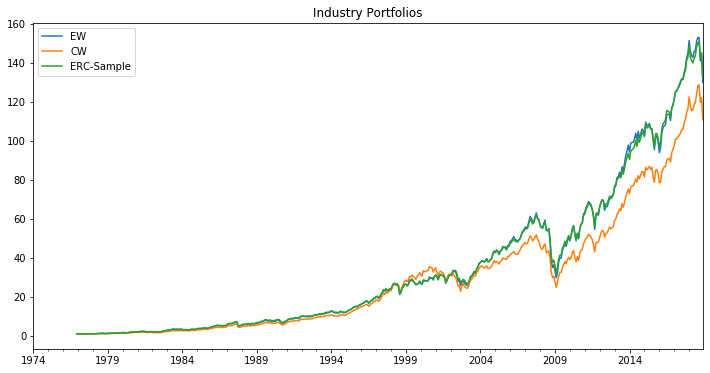

In [55]:
ewr = backtest_ws(ind_rets, estimation_window=36, weighting=weight_ew)
cwr = backtest_ws(ind_rets, estimation_window=36, weighting=weight_cw, cap_weights=ind_mcap)
mv_erc_r = backtest_ws(ind_rets, estimation_window=36, weighting=weight_erc, cov_estimator=sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "ERC-Sample": mv_erc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
summary_stats(btr.dropna())